<a href="https://colab.research.google.com/github/EAName/yelp-reviews/blob/main/Yelp_RandomForest_XGBoost_AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration & Import Modules

In [1]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [37]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split, GridSearchCV # cross-validation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import scikitplot as skplt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Ingest Business Clean 6

In [4]:
FILE = '/content/gdrive/MyDrive/yelp_dataset/yelp_business_clean_version6.csv'

In [5]:
df = pd.read_csv( FILE )
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Chicken Wings,Sports Bars,JapaneseTotal,HasTV_NA,RestaurantsPriceRange2_NA,RestaurantsReservations_NA,garage_NA,validated_NA,lot_NA,valet_NA
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123.0,38.565165,-90.321087,3.0,19,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227.0,39.637133,-86.127217,2.5,28,...,0,0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106.0,39.953949,-75.143226,4.0,245,...,0,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147.0,39.943223,-75.162568,4.5,205,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502.0,39.476117,-119.789339,2.5,339,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.shape

(30930, 69)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30930 entries, 0 to 30929
Data columns (total 69 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 30930 non-null  object 
 1   name                        30930 non-null  object 
 2   address                     30908 non-null  object 
 3   city                        30930 non-null  object 
 4   state                       30930 non-null  object 
 5   postal_code                 30929 non-null  float64
 6   latitude                    30930 non-null  float64
 7   longitude                   30930 non-null  float64
 8   stars                       30930 non-null  float64
 9   review_count                30930 non-null  int64  
 10  is_open                     30930 non-null  int64  
 11  attributes                  30930 non-null  object 
 12  categories                  30930 non-null  object 
 13  market                      309

In [9]:
df.describe()

,postal_code,latitude,longitude,stars,review_count,is_open,RestaurantsTakeOut,HasTV,BusinessAcceptsCreditCards,RestaurantsPriceRange2,...,Chicken Wings,Sports Bars,JapaneseTotal,HasTV_NA,RestaurantsPriceRange2_NA,RestaurantsReservations_NA,garage_NA,validated_NA,lot_NA,valet_NA
count,30929.000000,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000,...,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000,30930.000000
mean,42042.214039,36.217331,-86.339262,3.587650,112.821403,0.615616,0.923278,0.727190,0.960944,1.606143,...,0.051988,0.051697,0.064113,0.068607,0.065503,0.056385,0.090268,0.092079,0.097026,0.061849
std,24953.712732,4.909995,12.834677,0.694823,217.585630,0.486457,0.266154,0.445411,0.193731,0.695106,...,0.222007,0.221419,0.244957,0.252788,0.247415,0.230668,0.286570,0.289142,0.295997,0.240886
min,7836.000000,27.564457,-120.083748,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19147.000000,30.029444,-90.100177,3.000000,20.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34609.000000,38.783002,-82.756512,3.500000,51.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,63112.000000,39.950214,-75.291954,4.000000,124.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,336140.000000,43.773686,-74.664459,5.000000,7568.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


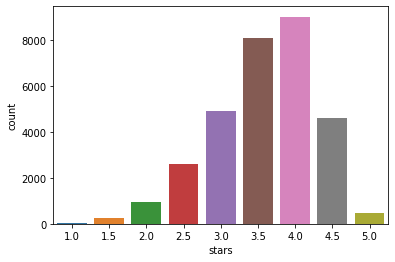

In [8]:
sns.countplot(x='stars', data=df);

# Prep df for linear model: drop columns

In [44]:
df_rf = df.copy(deep = True)

In [45]:
#Drop unnecessary columns and columns from EDA on mean star rating
# Won't drop as much for random forest and let model decide

df_rf.drop(["business_id","name","address","city","postal_code","latitude",
              "longitude","attributes","categories","BusinessParking"], axis =1, inplace = True)

'''
df_rf.drop(["business_id","name","address","city","state","postal_code","latitude",
              "longitude","attributes","categories","BusinessParking","market",'Alcohol_None', 
              'BYOBCorkage_yes_free', 'NoiseLevel_average', 'NoiseLevel_quiet',
              'Smoking_yes', 'WiFi_no', 'Nightlife', 'Bars', 'Sandwiches'], axis =1, inplace = True)
'''


'\ndf_rf.drop(["business_id","name","address","city","state","postal_code","latitude",\n              "longitude","attributes","categories","BusinessParking","market",\'Alcohol_None\', \n              \'BYOBCorkage_yes_free\', \'NoiseLevel_average\', \'NoiseLevel_quiet\',\n              \'Smoking_yes\', \'WiFi_no\', \'Nightlife\', \'Bars\', \'Sandwiches\'], axis =1, inplace = True)\n'

In [46]:
df_rf.shape

(30930, 59)

In [47]:
df_rf.head()

,state,stars,review_count,is_open,market,RestaurantsTakeOut,HasTV,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsReservations,AgesAllowed_21plus,AgesAllowed_allages,Alcohol_None,Alcohol_beer_and_wine,Alcohol_full_bar,BYOBCorkage_no,BYOBCorkage_yes_corkage,BYOBCorkage_yes_free,NoiseLevel_average,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,RestaurantsAttire_casual,RestaurantsAttire_dressy,RestaurantsAttire_formal,Smoking_no,Smoking_outdoor,Smoking_yes,WiFi_free,WiFi_no,WiFi_paid,garage,street,validated,lot,valet,Nightlife,Bars,American (Traditional),Pizza,American (New),Sandwiches,Italian,Breakfast & Brunch,Mexican,Seafood,ChineseTotal,Burgers,Salad,Chicken Wings,Sports Bars,JapaneseTotal,HasTV_NA,RestaurantsPriceRange2_NA,RestaurantsReservations_NA,garage_NA,validated_NA,lot_NA,valet_NA
0,MO,3.0,19,0,St. Louis,1.0,1.0,1.0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,IN,2.5,28,1,Indianapolis,1.0,1.0,1.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,PA,4.0,245,1,Philadelphia,1.0,0.0,1.0,2.0,1.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,PA,4.5,205,1,Philadelphia,1.0,1.0,1.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NV,2.5,339,1,Reno,1.0,1.0,1.0,2.0,1.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Random Forest Model 1

## Data Prep

In [48]:
Xlinear = df_rf.drop(columns = ['stars'])
ylinear = df_rf['stars'].astype(str)

In [49]:
# convert categorical to dummy vars
Xlinear = pd.get_dummies(Xlinear)

In [50]:
# split df into test and train
X_train, X_test, y_train, y_test = train_test_split(Xlinear, ylinear, test_size = 0.2, random_state = 10)

In [51]:
X_train.shape

(24744, 79)

In [52]:
X_train.head()

,review_count,is_open,RestaurantsTakeOut,HasTV,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsReservations,AgesAllowed_21plus,AgesAllowed_allages,Alcohol_None,Alcohol_beer_and_wine,Alcohol_full_bar,BYOBCorkage_no,BYOBCorkage_yes_corkage,BYOBCorkage_yes_free,NoiseLevel_average,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,RestaurantsAttire_casual,RestaurantsAttire_dressy,RestaurantsAttire_formal,Smoking_no,Smoking_outdoor,Smoking_yes,WiFi_free,WiFi_no,WiFi_paid,garage,street,validated,lot,valet,Nightlife,Bars,American (Traditional),Pizza,American (New),Sandwiches,Italian,Breakfast & Brunch,Mexican,Seafood,ChineseTotal,Burgers,Salad,Chicken Wings,Sports Bars,JapaneseTotal,HasTV_NA,RestaurantsPriceRange2_NA,RestaurantsReservations_NA,garage_NA,validated_NA,lot_NA,valet_NA,state_AZ,state_CA,state_DE,state_FL,state_ID,state_IL,state_IN,state_LA,state_MO,state_NJ,state_NV,state_PA,state_TN,market_Boise,market_Indianapolis,market_Nashville,market_New Orleans,market_Philadelphia,market_Reno,market_Santa Barbara,market_St. Louis,market_Tampa,market_Tucson
27482,38,0,1.0,1.0,1.0,2.0,0.0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
25724,44,1,1.0,1.0,1.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
14468,26,0,0.0,1.0,1.0,2.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
13120,6,0,1.0,0.0,1.0,1.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
481,69,1,1.0,1.0,1.0,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


## Fit Model

In [53]:
%%time
rfc = RandomForestClassifier(random_state=5, n_jobs=-1)

parameters_rfc = {'n_estimators': [10, 50, 200], 
                  #  'max_leaf_nodes': 16,
                  'max_features': ['auto', 'sqrt', 'log2'], 
                  'max_depth': [16, 32, 50], 
                  'criterion': ['gini', 'entropy']}

gscv_rfc = GridSearchCV(rfc, parameters_rfc, cv=3, scoring='accuracy', verbose=1)

gscv_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
CPU times: user 1min 56s, sys: 19.7 s, total: 2min 16s
Wall time: 6min 32s


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=5),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [16, 32, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 200]},
             scoring='accuracy', verbose=1)

## Training Performance

In [54]:
print('Best accuracy:', gscv_rfc.best_score_)
print('Best parameters:', gscv_rfc.best_params_)

Best accuracy: 0.3482460394439056
Best parameters: {'criterion': 'gini', 'max_depth': 16, 'max_features': 'log2', 'n_estimators': 200}


In [55]:
importances = gscv_rfc.best_estimator_.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.to_csv('forest_importances.csv')

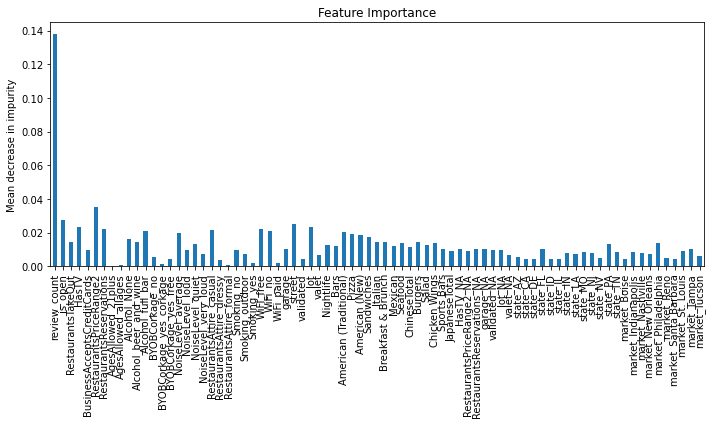

In [56]:
plt.rcParams['figure.figsize'] = (10, 6)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout();

# need to clean up variables with low importance

In [57]:
y_train_pred = gscv_rfc.predict(X_train)

In [58]:
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Train MAE:', (mean_absolute_error(y_train, y_train_pred)))

Train RMSE: 0.4753671985828665
Train MAE: 0.22712576786291627


In [59]:
print(classification_report(y_train, y_train_pred))

# accuracy is oddly much higher than in grid search

              precision    recall  f1-score   support

         1.0       1.00      0.50      0.67        22
         1.5       1.00      0.47      0.64       215
         2.0       0.98      0.43      0.59       770
         2.5       0.95      0.42      0.58      2034
         3.0       0.95      0.54      0.68      3953
         3.5       0.61      0.85      0.71      6447
         4.0       0.66      0.91      0.77      7257
         4.5       0.95      0.55      0.70      3668
         5.0       1.00      0.49      0.65       378

    accuracy                           0.71     24744
   macro avg       0.90      0.57      0.67     24744
weighted avg       0.78      0.71      0.71     24744



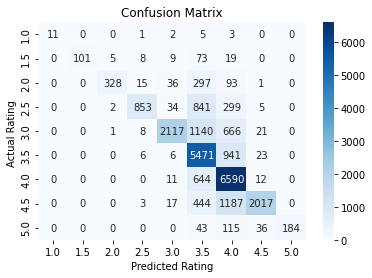

In [60]:
# Visual confusion matrix
plt.rcParams['figure.figsize'] = (6, 4)

cm_log = confusion_matrix(y_train, y_train_pred) # rows are actual survival, columns are predicted
ax = sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Actual Rating ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))
ax.yaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))

plt.show();

## Test Performance

In [61]:
# predict on test
y_test_pred = gscv_rfc.predict(X_test)

In [62]:
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('Test MAE:', (mean_absolute_error(y_test, y_test_pred)))

# much worse on test than on training

Test RMSE: 0.6657769685652764
Test MAE: 0.4802780472033624


In [63]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         1.0       0.50      0.14      0.22         7
         1.5       0.56      0.10      0.17        50
         2.0       0.25      0.03      0.05       195
         2.5       0.28      0.03      0.06       562
         3.0       0.27      0.08      0.13       970
         3.5       0.30      0.45      0.36      1625
         4.0       0.37      0.63      0.46      1751
         4.5       0.40      0.17      0.24       919
         5.0       0.33      0.01      0.02       107

    accuracy                           0.34      6186
   macro avg       0.36      0.18      0.19      6186
weighted avg       0.33      0.34      0.29      6186



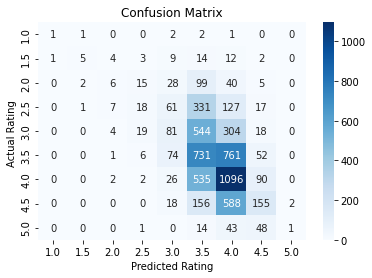

In [64]:
# Visual confusion matrix
plt.rcParams['figure.figsize'] = (6, 4)

cm_log = confusion_matrix(y_test, y_test_pred) # rows are actual survival, columns are predicted
ax = sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Actual Rating ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))
ax.yaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))

plt.show();

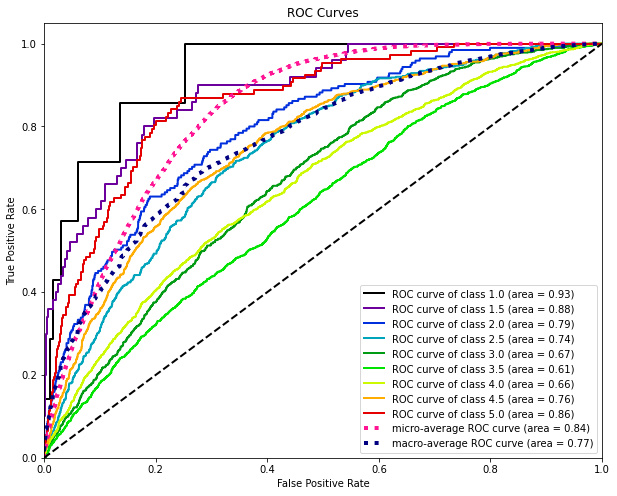

In [65]:
y_probas = gscv_rfc.predict_proba(X_test)

plt.rcParams["figure.figsize"] = (10,8)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

In [66]:
print('roc score = ', roc_auc_score(y_test, y_probas, multi_class = 'ovr')) # ovr means one vs. rest. AUC computed of each class against rest

roc score =  0.7675144993234521


# Random Forest Model 2: drop half of features with lowest importance

## Data Prep

In [67]:
Xlinear = df_rf.drop(columns = ['stars'])
ylinear = df_rf['stars'].astype(str)

In [68]:
# convert categorical to dummy vars
Xlinear = pd.get_dummies(Xlinear)

In [69]:
# Drop 40 attributes (out of 79 total) with lowest importance based on RF #1
Xlinear.drop(["Smoking_no",
            "BusinessAcceptsCreditCards",
            "NoiseLevel_loud",
            "lot_NA",
            "validated_NA",
            "market_St. Louis",
            "JapaneseTotal",
            "RestaurantsPriceRange2_NA",
            "state_MO",
            "state_TN",
            "market_Indianapolis",
            "market_Nashville",
            "state_NJ",
            "state_IN",
            "state_LA",
            "market_New Orleans",
            "Smoking_outdoor",
            "NoiseLevel_very_loud",
            "valet",
            "valet_NA",
            "market_Tucson",
            "state_AZ",
            "BYOBCorkage_no",
            "market_Reno",
            "state_NV",
            "state_DE",
            "validated",
            "state_CA",
            "BYOBCorkage_yes_free",
            "market_Santa Barbara",
            "market_Boise",
            "state_IL",
            "state_ID",
            "RestaurantsAttire_dressy",
            "WiFi_paid",
            "Smoking_yes",
            "BYOBCorkage_yes_corkage",
            "AgesAllowed_allages",
            "RestaurantsAttire_formal",
            "AgesAllowed_21plus"], axis =1, inplace = True)

In [70]:
# split df into test and train
X_train, X_test, y_train, y_test = train_test_split(Xlinear, ylinear, test_size = 0.2, random_state = 10)

In [71]:
X_train.shape

(24744, 39)

In [72]:
X_train.head()

,review_count,is_open,RestaurantsTakeOut,HasTV,RestaurantsPriceRange2,RestaurantsReservations,Alcohol_None,Alcohol_beer_and_wine,Alcohol_full_bar,NoiseLevel_average,NoiseLevel_quiet,RestaurantsAttire_casual,WiFi_free,WiFi_no,garage,street,lot,Nightlife,Bars,American (Traditional),Pizza,American (New),Sandwiches,Italian,Breakfast & Brunch,Mexican,Seafood,ChineseTotal,Burgers,Salad,Chicken Wings,Sports Bars,HasTV_NA,RestaurantsReservations_NA,garage_NA,state_FL,state_PA,market_Philadelphia,market_Tampa
27482,38,0,1.0,1.0,2.0,0.0,0,1,0,1,0,1,0,1,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0,0,0,0
25724,44,1,1.0,1.0,1.0,0.0,1,0,0,0,1,1,0,1,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,1,1,0
14468,26,0,0.0,1.0,2.0,1.0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,1,1,0
13120,6,0,1.0,0.0,1.0,0.0,1,0,0,1,0,1,1,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,1,0
481,69,1,1.0,1.0,3.0,0.0,0,0,0,0,0,1,1,0,0.0,0.0,0.0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0,0,0,0


## Fit Model

In [23]:
%%time
rfc = RandomForestClassifier(random_state=5, n_jobs=-1)

parameters_rfc = {'n_estimators': [10, 50, 200], 
                  #  'max_leaf_nodes': 16,
                  'max_features': ['auto', 'sqrt', 'log2'], 
                  'max_depth': [16, 32, 50], 
                  'criterion': ['gini', 'entropy']}

gscv_rfc = GridSearchCV(rfc, parameters_rfc, cv=3, scoring='accuracy', verbose=1)

gscv_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
CPU times: user 1min 48s, sys: 20.9 s, total: 2min 8s
Wall time: 5min 38s


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=5),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [16, 32, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 200]},
             scoring='accuracy', verbose=1)

## Training Performance

In [24]:
print('Best accuracy:', gscv_rfc.best_score_)
print('Best parameters:', gscv_rfc.best_params_)

Best accuracy: 0.34218396378920146
Best parameters: {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'log2', 'n_estimators': 200}


In [25]:
importances = gscv_rfc.best_estimator_.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.to_csv('forest_importances.csv')

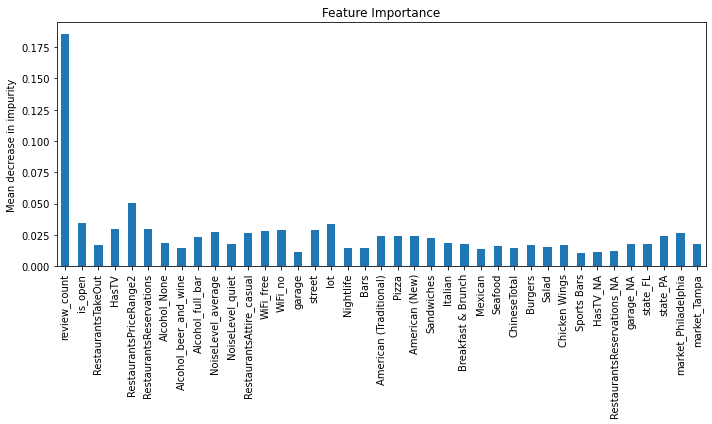

In [26]:
plt.rcParams['figure.figsize'] = (10, 6)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout();

# need to clean up variables with low importance

In [27]:
y_train_pred = gscv_rfc.predict(X_train)

In [28]:
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Train MAE:', (mean_absolute_error(y_train, y_train_pred)))

Train RMSE: 0.36915506324273784
Train MAE: 0.13732622049789847


In [29]:
print(classification_report(y_train, y_train_pred))

# accuracy is oddly much higher than in grid search

              precision    recall  f1-score   support

         1.0       1.00      0.77      0.87        22
         1.5       1.00      0.67      0.81       215
         2.0       0.98      0.65      0.78       770
         2.5       0.95      0.64      0.77      2034
         3.0       0.94      0.74      0.83      3953
         3.5       0.75      0.90      0.82      6447
         4.0       0.77      0.93      0.85      7257
         4.5       0.98      0.74      0.84      3668
         5.0       0.99      0.72      0.84       378

    accuracy                           0.83     24744
   macro avg       0.93      0.75      0.82     24744
weighted avg       0.85      0.83      0.83     24744



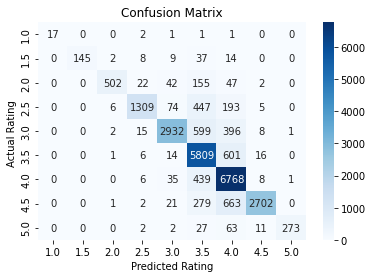

In [30]:
# Visual confusion matrix
plt.rcParams['figure.figsize'] = (6, 4)

cm_log = confusion_matrix(y_train, y_train_pred) # rows are actual survival, columns are predicted
ax = sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Actual Rating ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))
ax.yaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))

plt.show();

## Test Performance

In [31]:
# predict on test
y_test_pred = gscv_rfc.predict(X_test)

In [32]:
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('Test MAE:', (mean_absolute_error(y_test, y_test_pred)))

# much worse on test than on training

Test RMSE: 0.6737719487051582
Test MAE: 0.4902198512770773


In [33]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         1.0       0.50      0.14      0.22         7
         1.5       0.44      0.16      0.24        50
         2.0       0.21      0.04      0.06       195
         2.5       0.25      0.06      0.10       562
         3.0       0.24      0.14      0.18       970
         3.5       0.30      0.41      0.35      1625
         4.0       0.37      0.58      0.45      1751
         4.5       0.39      0.20      0.26       919
         5.0       0.00      0.00      0.00       107

    accuracy                           0.33      6186
   macro avg       0.30      0.19      0.21      6186
weighted avg       0.31      0.33      0.30      6186



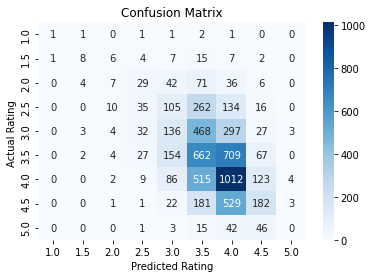

In [34]:
# Visual confusion matrix
plt.rcParams['figure.figsize'] = (6, 4)

cm_log = confusion_matrix(y_test, y_test_pred) # rows are actual survival, columns are predicted
ax = sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Actual Rating ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))
ax.yaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))

plt.show();

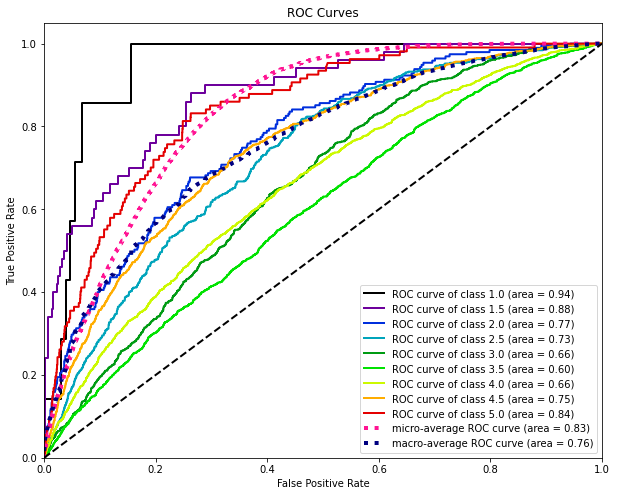

In [39]:
y_probas = gscv_rfc.predict_proba(X_test)

plt.rcParams["figure.figsize"] = (10,8)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

In [40]:
print('roc score = ', roc_auc_score(y_test, y_probas, multi_class = 'ovr')) # ovr means one vs. rest. AUC computed of each class against rest

# overall a bit worse than RF #1 but half the training time

roc score =  0.758417855135945


# Random Forest Model 3: change hyperparameters

## Fit Model

In [73]:
%%time
rfc = RandomForestClassifier(random_state=5, n_jobs=-1)

parameters_rfc = {'n_estimators': [100, 200, 300, 400], 
                  #  'max_leaf_nodes': 16,
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'max_depth': [4, 8, 16, 32],
                  'criterion': ['gini', 'entropy']}

gscv_rfc = GridSearchCV(rfc, parameters_rfc, cv=3, scoring='accuracy', verbose=1)

gscv_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
CPU times: user 5min 32s, sys: 54.4 s, total: 6min 26s
Wall time: 17min 23s


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=5),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 16, 32],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy', verbose=1)

## Training Performance

In [74]:
print('Best accuracy:', gscv_rfc.best_score_)
print('Best parameters:', gscv_rfc.best_params_)

Best accuracy: 0.34703362431296475
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 300}


In [75]:
importances = gscv_rfc.best_estimator_.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.to_csv('forest_importances.csv')

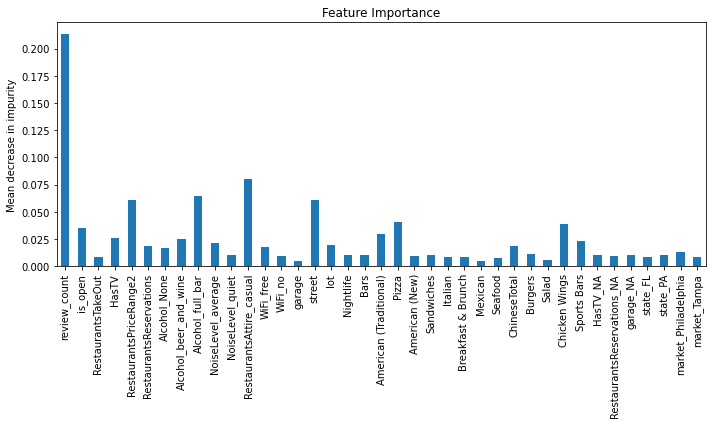

In [76]:
plt.rcParams['figure.figsize'] = (10, 6)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout();

# need to clean up variables with low importance

In [77]:
y_train_pred = gscv_rfc.predict(X_train)

In [78]:
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Train MAE:', (mean_absolute_error(y_train, y_train_pred)))

Train RMSE: 0.6477394225469839
Train MAE: 0.4499070481732945


In [79]:
print(classification_report(y_train, y_train_pred))

# accuracy is closer to grid search so doesn't seem to overfit like prior 2 models

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        22
         1.5       0.80      0.06      0.10       215
         2.0       0.61      0.04      0.08       770
         2.5       0.49      0.05      0.10      2034
         3.0       0.45      0.04      0.07      3953
         3.5       0.34      0.53      0.41      6447
         4.0       0.41      0.73      0.53      7257
         4.5       0.53      0.17      0.26      3668
         5.0       0.00      0.00      0.00       378

    accuracy                           0.39     24744
   macro avg       0.40      0.18      0.17     24744
weighted avg       0.43      0.39      0.32     24744



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


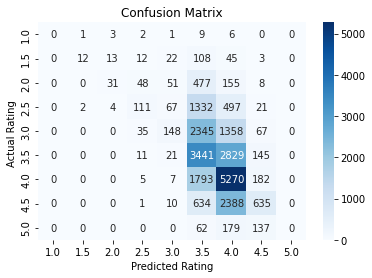

In [80]:
# Visual confusion matrix
plt.rcParams['figure.figsize'] = (6, 4)

cm_log = confusion_matrix(y_train, y_train_pred) # rows are actual survival, columns are predicted
ax = sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Actual Rating ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))
ax.yaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))

plt.show();

## Test Performance

In [81]:
# predict on test
y_test_pred = gscv_rfc.predict(X_test)

In [82]:
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('Test MAE:', (mean_absolute_error(y_test, y_test_pred)))

# much worse on test than on training

Test RMSE: 0.6786726075542042
Test MAE: 0.4923213708373747


In [83]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         1.5       0.33      0.02      0.04        50
         2.0       0.33      0.02      0.04       195
         2.5       0.32      0.03      0.05       562
         3.0       0.27      0.02      0.03       970
         3.5       0.30      0.47      0.36      1625
         4.0       0.36      0.66      0.46      1751
         4.5       0.41      0.13      0.20       919
         5.0       0.00      0.00      0.00       107

    accuracy                           0.33      6186
   macro avg       0.26      0.15      0.13      6186
weighted avg       0.32      0.33      0.27      6186



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


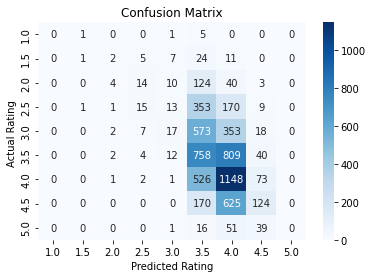

In [84]:
# Visual confusion matrix
plt.rcParams['figure.figsize'] = (6, 4)

cm_log = confusion_matrix(y_test, y_test_pred) # rows are actual survival, columns are predicted
ax = sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Actual Rating ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))
ax.yaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))

plt.show();

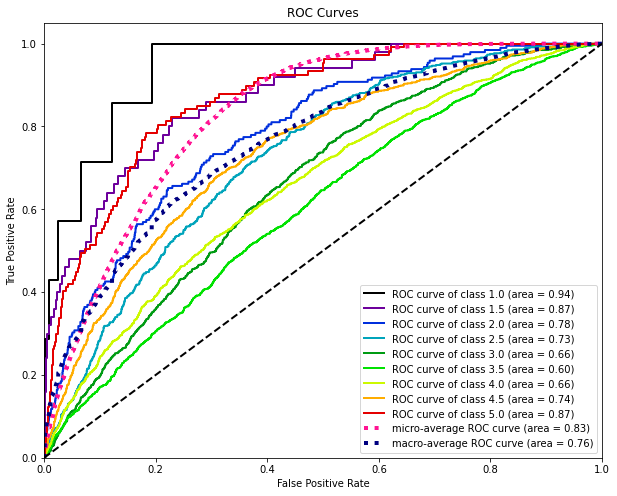

In [85]:
y_probas = gscv_rfc.predict_proba(X_test)

plt.rcParams["figure.figsize"] = (10,8)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

In [86]:
print('roc score = ', roc_auc_score(y_test, y_probas, multi_class = 'ovr')) # ovr means one vs. rest. AUC computed of each class against rest

# overall a bit worse than RF #1 but half the training time

roc score =  0.7611839617925107


# XGBoost Model 1

## Fit Model

In [22]:
%%time
xgbc = xgb.XGBClassifier(random_state=5, eval_metric='logloss')

parameters_xgbc = {'n_estimators': [10, 50, 200],
                  'max_depth': [16, 32, 50],
                  'learning_rate': [0.1]} # 0.01, 0.05, 

gscv_xgbc = GridSearchCV(xgbc, parameters_xgbc, cv=3, scoring='accuracy', return_train_score=True, verbose=1)

gscv_xgbc.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
CPU times: user 1h 28min 38s, sys: 9.48 s, total: 1h 28min 47s
Wall time: 1h 28min 31s


GridSearchCV(cv=3,
             estimator=XGBClassifier(eval_metric='logloss', random_state=5),
             param_grid={'learning_rate': [0.1], 'max_depth': [16, 32, 50],
                         'n_estimators': [10, 50, 200]},
             return_train_score=True, scoring='accuracy', verbose=1)

## Training Performance

In [23]:
print('Best accuracy:', gscv_xgbc.best_score_)
print('Best parameters:', gscv_xgbc.best_params_)

# not better than RF and took much longer. Probably because data is sparse

Best accuracy: 0.32803912059489165
Best parameters: {'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 50}


In [30]:
importances = gscv_xgbc.best_estimator_.feature_importances_
feature_names = X_train.columns
xgb_importances = pd.Series(importances, index=feature_names)
xgb_importances.to_csv('xgb_importances.csv')

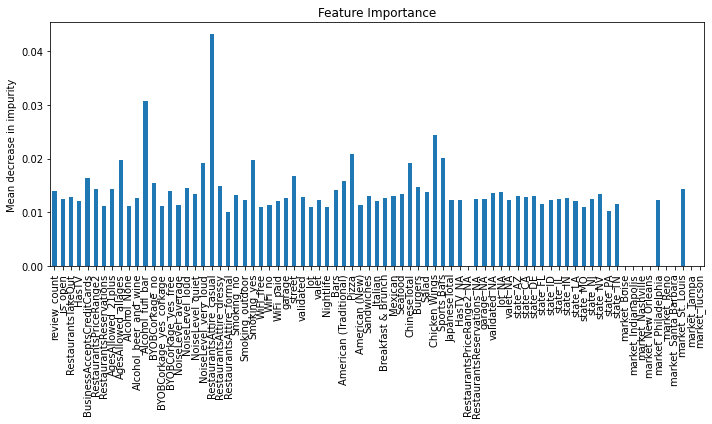

In [31]:
plt.rcParams['figure.figsize'] = (10, 6)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout();

# need to clean up variables with low importance

In [32]:
y_train_pred = gscv_xgbc.predict(X_train)

In [33]:
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Train MAE:', (mean_absolute_error(y_train, y_train_pred)))

Train RMSE: 0.28860512728576965
Train MAE: 0.07973650177820886


In [34]:
print(classification_report(y_train, y_train_pred))

# accuracy is oddly much higher than in grid search

              precision    recall  f1-score   support

         1.0       1.00      0.32      0.48        22
         1.5       0.97      0.82      0.89       215
         2.0       0.97      0.86      0.91       770
         2.5       0.97      0.81      0.88      2034
         3.0       0.93      0.85      0.89      3953
         3.5       0.84      0.93      0.88      6447
         4.0       0.89      0.95      0.92      7257
         4.5       0.97      0.89      0.93      3668
         5.0       0.98      0.86      0.92       378

    accuracy                           0.90     24744
   macro avg       0.95      0.81      0.86     24744
weighted avg       0.91      0.90      0.90     24744



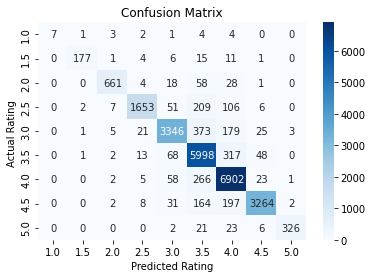

In [35]:
# Visual confusion matrix
plt.rcParams['figure.figsize'] = (6, 4)

cm_log = confusion_matrix(y_train, y_train_pred) # rows are actual survival, columns are predicted
ax = sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Actual Rating ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))
ax.yaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))

plt.show();

## Test Performance

In [36]:
# predict on test
y_test_pred = gscv_xgbc.predict(X_test)

In [37]:
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('Test MAE:', (mean_absolute_error(y_test, y_test_pred)))

# much worse on test than on training

Test RMSE: 0.7065350120454325
Test MAE: 0.5093760103459425


In [38]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         1.5       0.36      0.20      0.26        50
         2.0       0.21      0.08      0.12       195
         2.5       0.25      0.10      0.15       562
         3.0       0.26      0.20      0.23       970
         3.5       0.31      0.39      0.35      1625
         4.0       0.36      0.49      0.42      1751
         4.5       0.35      0.27      0.30       919
         5.0       0.04      0.01      0.01       107

    accuracy                           0.33      6186
   macro avg       0.24      0.19      0.20      6186
weighted avg       0.31      0.33      0.31      6186



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


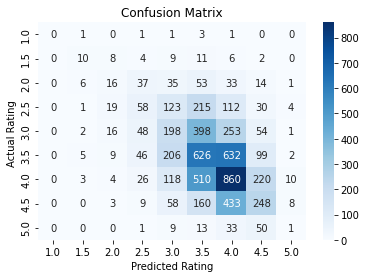

In [39]:
# Visual confusion matrix
plt.rcParams['figure.figsize'] = (6, 4)

cm_log = confusion_matrix(y_test, y_test_pred) # rows are actual survival, columns are predicted
ax = sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Actual Rating ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))
ax.yaxis.set_ticklabels(list(np.arange(1, 5.5, 0.5)))

plt.show();

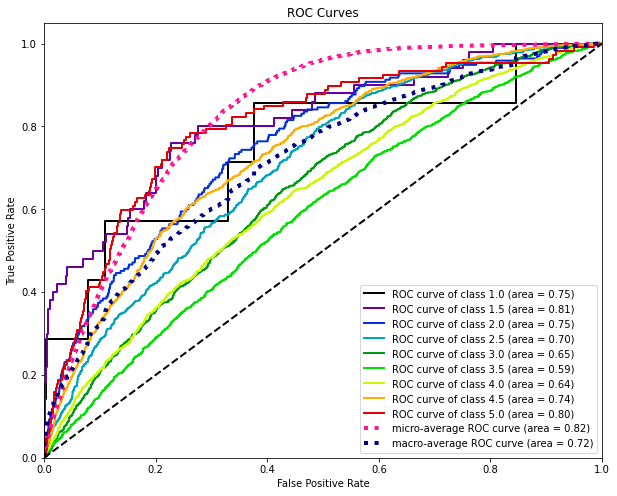

In [92]:
y_probas = gscv_xgbc.predict_proba(X_test)

plt.rcParams["figure.figsize"] = (10,8)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

In [102]:
print('roc score = ', roc_auc_score(y_test, y_probas, multi_class = 'ovr')) # ovr means one vs. rest. AUC computed of each class against rest

roc score =  0.7151019830902687
